<a href="https://colab.research.google.com/github/KyungRyeolBaek/study/blob/main/AI%20study/ODE/ErrorCorr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Error Corr

In [1]:
import autograd.numpy as np
from autograd import grad 
import autograd.numpy.random as npr
from autograd.core import primitive
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import torch

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
nx = 10
dx = 1. / nx

def A(x):
    '''
        Left part of initial equation
    '''
    return x + (1. + 3.*x**2) / (1. + x + x**3)


def B(x):
    '''
        Right part of initial equation
    '''
    return x**3 + 2.*x + x**2 * ((1. + 3.*x**2) / (1. + x + x**3))


def f(x, psy):
    '''
        d(psy)/dx = f(x, psy)
        This is f() function on the right
    '''
    return B(x) - psy * A(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))


def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])


def d_neural_network_dx(W, x, k=1):
    return np.dot(np.dot(W[1].T, W[0].T**k), sigmoid_grad(x))


def loss_function(W, x):
    loss_sum = 0.
    for xi in x:
        net_out = neural_network(W, xi)[0][0]
        psy_t = 1. + xi * net_out
        d_net_out = d_neural_network_dx(W, xi)[0][0]
        d_psy_t = net_out + xi * d_net_out
        func = f(xi, psy_t)       
        err_sqr = (d_psy_t - func)**2

        loss_sum += err_sqr
    return loss_sum

# x_space = np.linspace(0, 1, nx)
# W = [npr.randn(1, 10), npr.randn(10, 1)]
# lmb = 0.001

# for i in range(1000):
#     loss_grad =  grad(loss_function)(W, x_space)
    
#     W[0] = W[0] - lmb * loss_grad[0]
#     W[1] = W[1] - lmb * loss_grad[1]

# res = [1 + xi * neural_network(W, xi)[0][0] for xi in x_space] 

In [3]:
def graph_N(w_number, x_number, step_number):
  y = 1
  yprime = 0
  x = tf.Variable(tf.random_normal([x_number]), name = 'x')

  for i in range(1, w_number + 1):
    globals()['w{}'.format(i)] = tf.Variable(tf.random_normal([1]), name = 'weight{}'.format(i))
    y += globals()['w{}'.format(i)]*(x**i)  # y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + w5*(x**5) + w6*(x**6)
    yprime += i*globals()['w{}'.format(i)]*(x**(i-1))  # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3) + 5*w5*(x**4) + 6*w6*(x**5)
  
  x_space = np.linspace(-4, 4, x_number)
  W = [npr.randn(1, w_number), npr.randn(w_number, 1)]
  lmb = 0.001

  for i in range(1000):
    loss_grad =  grad(loss_function)(W, x_space)
    
    W[0] = W[0] - lmb * loss_grad[0]
    W[1] = W[1] - lmb * loss_grad[1]

  y += torch.Tensor([neural_network(W, xi)[0][0] for xi in x_space] )
  yprime += torch.Tensor(neural_network(W, 1)[0][0] + d_neural_network_dx(W, 1)*x_space)

  cost = tf.reduce_mean(tf.square(yprime - y))
  optimizer = tf.train.GradientDescentOptimizer(learning_rate = 1e-5)
  train = optimizer.minimize(cost)

  sess = tf.Session()
  sess.run(tf.global_variables_initializer())

  for step in range(step_number + 1):
    for i in range(1, w_number + 1):
        globals()['w{}_val'.format(i)] = sess.run([globals()['w{}'.format(i)]])
    cost_val, yprime_val, y_val, x_val, _ = sess.run([cost, yprime, y, x, train])
    if step % int(step_number / 5) == 0:
  #         print(step, "Cost: ", cost_val, "\nx: ", x_val,  "yprime: ", yprime_val, "y: ", y_val)
        print(step, "Cost: ", cost_val, "\n")
        print("w1: ", w1_val, "w2: ", w2_val, "w3: ", w3_val, "w4: ", w4_val, "w5: ", w5_val, "w6: ", w6_val, "\n")
        
  def y(x):
    answer = 1
    for i in range(1, w_number + 1):
        answer += globals()['w{}_val'.format(i)]*(x**i)
    return answer[0]

  globals()['w{}x{}'.format(w_number, x_number)] = [x_val, y(x_val)]
  plt.plot(x_val, y(x_val), '.')
  plt.show()

0 Cost:  24315.99 

w1:  [array([0.720313], dtype=float32)] w2:  [array([-0.11088338], dtype=float32)] w3:  [array([-0.8730286], dtype=float32)] w4:  [array([-0.12122729], dtype=float32)] w5:  [array([0.771264], dtype=float32)] w6:  [array([2.012427], dtype=float32)] 

6000 Cost:  1.2354578 

w1:  [array([0.63914126], dtype=float32)] w2:  [array([-0.14555836], dtype=float32)] w3:  [array([-1.0098164], dtype=float32)] w4:  [array([-0.5728918], dtype=float32)] w5:  [array([0.39954326], dtype=float32)] w6:  [array([0.351314], dtype=float32)] 

12000 Cost:  0.89722556 

w1:  [array([0.5465381], dtype=float32)] w2:  [array([-0.08965334], dtype=float32)] w3:  [array([-1.0495533], dtype=float32)] w4:  [array([-0.55496764], dtype=float32)] w5:  [array([0.36965778], dtype=float32)] w6:  [array([0.29768625], dtype=float32)] 

18000 Cost:  0.73234767 

w1:  [array([0.47052965], dtype=float32)] w2:  [array([-0.04407624], dtype=float32)] w3:  [array([-1.0642647], dtype=float32)] w4:  [array([-0.532

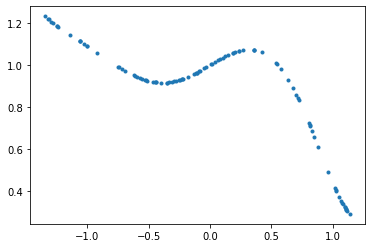

/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


0 Cost:  nan 

w1:  [array([0.4393215], dtype=float32)] w2:  [array([0.36696914], dtype=float32)] w3:  [array([0.8621625], dtype=float32)] w4:  [array([-0.7573], dtype=float32)] w5:  [array([0.19124465], dtype=float32)] w6:  [array([-0.04025832], dtype=float32)] 

6000 Cost:  nan 

w1:  [array([nan], dtype=float32)] w2:  [array([nan], dtype=float32)] w3:  [array([nan], dtype=float32)] w4:  [array([nan], dtype=float32)] w5:  [array([nan], dtype=float32)] w6:  [array([nan], dtype=float32)] 

12000 Cost:  nan 

w1:  [array([nan], dtype=float32)] w2:  [array([nan], dtype=float32)] w3:  [array([nan], dtype=float32)] w4:  [array([nan], dtype=float32)] w5:  [array([nan], dtype=float32)] w6:  [array([nan], dtype=float32)] 

18000 Cost:  nan 

w1:  [array([nan], dtype=float32)] w2:  [array([nan], dtype=float32)] w3:  [array([nan], dtype=float32)] w4:  [array([nan], dtype=float32)] w5:  [array([nan], dtype=float32)] w6:  [array([nan], dtype=float32)] 

24000 Cost:  nan 

w1:  [array([nan], dtype

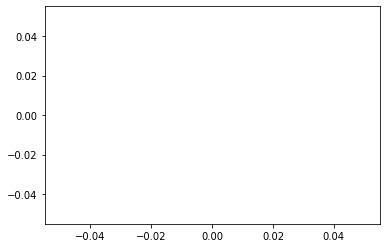

/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)


0 Cost:  nan 

w1:  [array([0.30821353], dtype=float32)] w2:  [array([0.6569976], dtype=float32)] w3:  [array([0.46274525], dtype=float32)] w4:  [array([0.16459513], dtype=float32)] w5:  [array([0.10649665], dtype=float32)] w6:  [array([1.3169963], dtype=float32)] 

6000 Cost:  nan 

w1:  [array([nan], dtype=float32)] w2:  [array([nan], dtype=float32)] w3:  [array([nan], dtype=float32)] w4:  [array([nan], dtype=float32)] w5:  [array([nan], dtype=float32)] w6:  [array([nan], dtype=float32)] 

12000 Cost:  nan 

w1:  [array([nan], dtype=float32)] w2:  [array([nan], dtype=float32)] w3:  [array([nan], dtype=float32)] w4:  [array([nan], dtype=float32)] w5:  [array([nan], dtype=float32)] w6:  [array([nan], dtype=float32)] 

18000 Cost:  nan 

w1:  [array([nan], dtype=float32)] w2:  [array([nan], dtype=float32)] w3:  [array([nan], dtype=float32)] w4:  [array([nan], dtype=float32)] w5:  [array([nan], dtype=float32)] w6:  [array([nan], dtype=float32)] 

24000 Cost:  nan 

w1:  [array([nan], dty

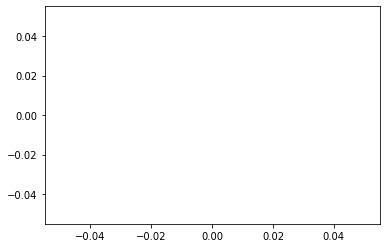

In [30]:
graph_N(6, 100, 30000)
graph_N(6, 1000, 30000)
graph_N(6, 10000, 30000)

/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)


0 Cost:  nan 

w1:  [array([0.7614861], dtype=float32)] w2:  [array([1.9688549], dtype=float32)] w3:  [array([0.43788782], dtype=float32)] w4:  [array([-0.0140209], dtype=float32)] w5:  [array([-0.57783574], dtype=float32)] w6:  [array([-1.1678511], dtype=float32)] 

60 Cost:  nan 

w1:  [array([nan], dtype=float32)] w2:  [array([nan], dtype=float32)] w3:  [array([nan], dtype=float32)] w4:  [array([nan], dtype=float32)] w5:  [array([nan], dtype=float32)] w6:  [array([nan], dtype=float32)] 

120 Cost:  nan 

w1:  [array([nan], dtype=float32)] w2:  [array([nan], dtype=float32)] w3:  [array([nan], dtype=float32)] w4:  [array([nan], dtype=float32)] w5:  [array([nan], dtype=float32)] w6:  [array([nan], dtype=float32)] 

180 Cost:  nan 

w1:  [array([nan], dtype=float32)] w2:  [array([nan], dtype=float32)] w3:  [array([nan], dtype=float32)] w4:  [array([nan], dtype=float32)] w5:  [array([nan], dtype=float32)] w6:  [array([nan], dtype=float32)] 

240 Cost:  nan 

w1:  [array([nan], dtype=floa

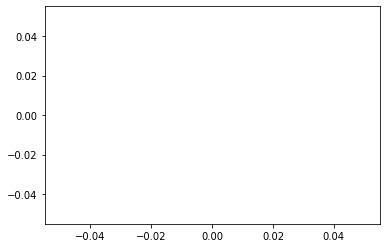

In [5]:
graph_N(10, 10, 300)

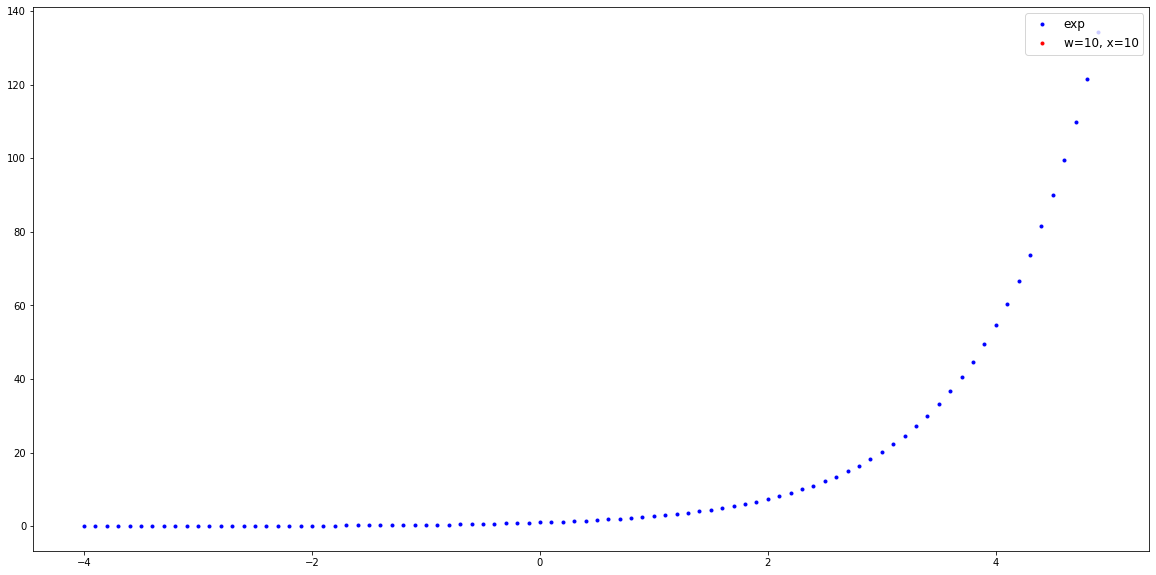

In [7]:
x = np.array([i for i in range(-40, 50, 1)])
plt.figure(figsize = (20, 10))
plt.plot(0.1*x, np.exp(0.1*x), '.b', label = 'exp')
plt.plot(w10x10[0],w10x10[1], '.r', label = 'w=10, x=10')
# plt.plot(w6x100[0],w6x100[1], '.r', label = 'w=6, x=100')
# plt.plot(w6x1000[0],w6x1000[1], '.g', label = 'w=6, x=1000')
# plt.plot(w6x10000[0],w6x10000[1], '.c', label = 'w=6, x=10000')
plt.legend(loc = 'upper right', fontsize = 'large')

plt.show()